In [4]:
import diffrax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from mcmc import run_sortmc
from numpyro import diagnostics, distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy import stats


jnp.set_printoptions(precision=4, suppress=True)
jax.config.update("jax_enable_x64", True)


def log_p_normal(x):
    return 0.5 * jnp.dot(x, x)


STD_X = 3.0


def std_y(x):
    return jnp.exp(jax.lax.stop_gradient(x) / 2.0)


@jax.jit
def potential_funnel(x):
    z_term = x[0] ** 2 / (2.0 * STD_X**2)
    y_term = jnp.sum(x[1:] ** 2) / (2.0 * std_y(x[0]) ** 2)
    return z_term + y_term


def funnel_model(dim=10):
    x = numpyro.sample("x", dist.Normal(jnp.zeros((1,)), STD_X))
    numpyro.sample("y", dist.Normal(jnp.zeros(dim - 1), std_y(x)))


def dict_to_array(dct: dict):
    x = jnp.expand_dims(dct["x"], dct["x"].ndim)
    return jnp.concatenate([x, dct["y"]], axis=-1)


@jax.jit
@jax.vmap
def funnel_true_samples(keys):
    key_x, key_y = jr.split(keys, 2)
    x = jr.normal(key_x, shape=(1,)) * STD_X
    y = jr.normal(key_y, shape=(9,)) * std_y(x)
    return jnp.concatenate([x, y])


def rescale_funnel(x):
    return jnp.concatenate([x[:1] / STD_X, x[1:] / std_y(x[0])])


vec_rescale_funnel = jax.jit(jax.vmap(rescale_funnel, in_axes=0))

x0_funnel = jnp.zeros((10,), dtype=jnp.float64)


FUNNEL_LIMS = (-10.0, 10.0)


def draw_funnel(samples):
    samples_rshp = jnp.reshape(samples, (-1, 10))
    fig, ax = plt.subplots(1, 1)
    ax.scatter(samples_rshp[:, 0], samples_rshp[:, 1], alpha=0.2, s=8.0)
    ax.set(xlim=FUNNEL_LIMS, ylim=FUNNEL_LIMS)
    plt.show()
    return fig


def evaluate_funnel(samples, grad_evals_per_sample: float = 0.0):
    def avg(x):
        x = jnp.array(x)
        weights = jnp.array([9] + [1] * 9, dtype=jnp.float64) / 18.0
        return jnp.dot(x, weights)

    def matrix_avg(x):
        x = jnp.array(x)
        one_dim = jax.vmap(avg, in_axes=0)(x)
        return avg(one_dim)

    samples_rshp = jnp.reshape(samples, (-1, 10))
    means = jnp.mean(samples_rshp, axis=0)
    max_mean_err = jnp.max(jnp.abs(means))
    avg_mean_err = avg(jnp.abs(means))
    samples_rescaled = vec_rescale_funnel(samples_rshp)
    cov = jnp.cov(samples_rescaled, rowvar=False)
    cov_err = jnp.abs(cov - jnp.eye(10))
    max_cov_err = jnp.max(cov_err)
    avg_cov_err = matrix_avg(cov_err)
    ref_dist = stats.norm(loc=0.0, scale=1.0)
    pvals = []
    for i in range(10):
        _, pval = stats.kstest(samples_rescaled[:, i], ref_dist.cdf)
        pvals.append(pval)
    min_pval = min(pvals)
    avg_pval = avg(pvals)
    if samples.ndim > 2:
        ess = diagnostics.effective_sample_size(samples) / samples_rshp.shape[0]
        min_ess = jnp.min(ess)
        avg_ess = avg(ess)
        # compute the number of gradient evaluations per effective sample
        if grad_evals_per_sample > 0:
            gepes = grad_evals_per_sample / avg_ess
            print(f"Gradient evaluations per effective sample: {gepes}")
    else:
        ess = 1.0
        min_ess = 1.0
        avg_ess = 1.0
    print(
        f"Max mean err: {max_mean_err:.4}, max cov err: {max_cov_err:.4},"
        f" min_pval: {min_pval:.4}, min_ess {min_ess:.4}"
    )
    print(
        f"Avg mean err: {avg_mean_err:.4}, avg cov err: {avg_cov_err:.4},"
        f" avg_pval: {avg_pval:.4}, avg_ess {avg_ess:.4}"
    )

    fig = draw_funnel(samples_rshp)

    return means, cov, pvals, ess, fig

In [5]:
# geps stands for gradient evals per sample
ys_funnel_sort, geps_sort = run_sortmc(
    jr.PRNGKey(8),
    potential_funnel,
    x0_funnel,
    64,
    2**7,
    2.0,
    2.0**-8,
    warmup_mult=16.0,
    warmup_tol_mult=4.0,
    solver=diffrax.SORT(0.01),
    use_adaptive=False,
)
jnp.save("funnel_data/funnel_sort.npy", ys_funnel_sort)

Steps warmup: 2048.0, steps mcmc: 67710.0, gradient evaluations per output: 1089.96875


Steps warmup: 225.984375, steps mcmc: 3187.734375, gradient evaluations per output: 53.33935546875
Gradient evaluations per effective sample: 401.5657382918161
Max mean err: 0.201, max cov err: 0.3365, min_pval: 1.17e-18, min_ess 0.1226
Avg mean err: 0.04709, avg cov err: 0.02782, avg_pval: 0.1739, avg_ess 0.1328


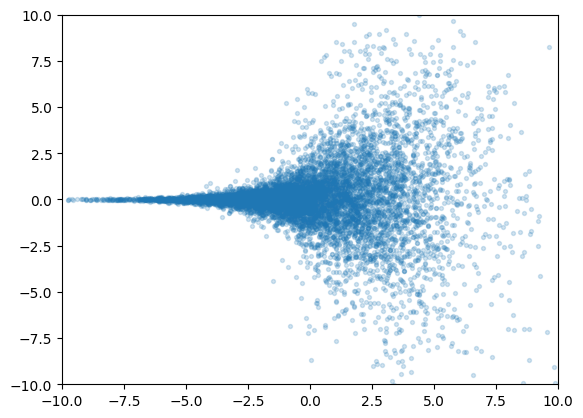

In [3]:
ys_funnel_sort_adap, geps_sort_adap = run_sortmc(
    jr.PRNGKey(0),
    potential_funnel,
    x0_funnel,
    64,
    2**7,
    2.0,
    2.0**-6,
    warmup_mult=16.0,
    warmup_tol_mult=4.0,
    solver=diffrax.SORT(0.01),
    use_adaptive=True,
)
jnp.save("funnel_data/funnel_sort_adap.npy", ys_funnel_sort_adap)

In [19]:
num_chains = 64
x0_funnel_broadcast = jnp.broadcast_to(x0_funnel, (num_chains,) + x0_funnel.shape)

kernel = NUTS(funnel_model, step_size=2.0)
nuts_funnel = MCMC(
    kernel,
    num_warmup=16,
    num_samples=2**7,
    num_chains=num_chains,
    chain_method="vectorized",
)
nuts_funnel.run(
    jr.PRNGKey(0),
    extra_fields=("num_steps",),
    init_params={
        "x": np.zeros((num_chains,), dtype=np.float64),
        "y": np.zeros((num_chains, 9), dtype=np.float64),
    },
)
ys_funnel_nuts_dict = nuts_funnel.get_samples(group_by_chain=True)
ys_funnel_nuts = dict_to_array(ys_funnel_nuts_dict)
jnp.save("funnel_data/funnel_nuts.npy", ys_funnel_nuts)
steps_nuts = nuts_funnel.get_extra_fields()["num_steps"]
geps_nuts = sum(steps_nuts) / len(steps_nuts)
print(geps_nuts)

700.187744140625


In [6]:
ys_funnel_euler, geps_euler = run_sortmc(
    jr.PRNGKey(0),
    potential_funnel,
    x0_funnel,
    64,
    2**7,
    2.0,
    2.0**-6,
    warmup_mult=16.0,
    warmup_tol_mult=4.0,
    use_adaptive=False,
    solver=diffrax.Euler(),
)
jnp.save("funnel_data/funnel_euler.npy", ys_funnel_euler)

Steps warmup: 512.0, steps mcmc: 17022.0, gradient evaluations per output: 136.984375


Gradient evaluations per effective sample: 34038.734547681976
Max mean err: 0.7929, max cov err: 0.556, min_pval: 8.035e-219, min_ess 0.009243
Avg mean err: 0.436, avg cov err: 0.1554, avg_pval: 0.04434, avg_ess 0.02057


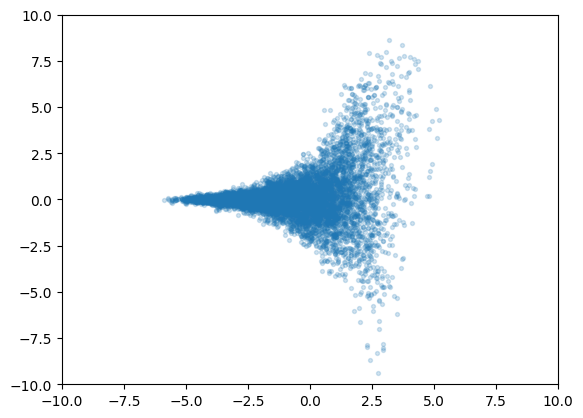

700.187744140625


In [12]:
ys_funnel_nuts = jnp.load("funnel_data/funnel_nuts.npy")
_, _, _, _, fig_nuts = evaluate_funnel(ys_funnel_nuts, geps_nuts)
fig_nuts.savefig("graphs/funnel_nuts.pdf")
print(geps_nuts)

Gradient evaluations per effective sample: nan
Max mean err: 0.1193, max cov err: 151.0, min_pval: 0.0, min_ess nan
Avg mean err: 0.06893, avg cov err: 4.913, avg_pval: 0.0, avg_ess nan


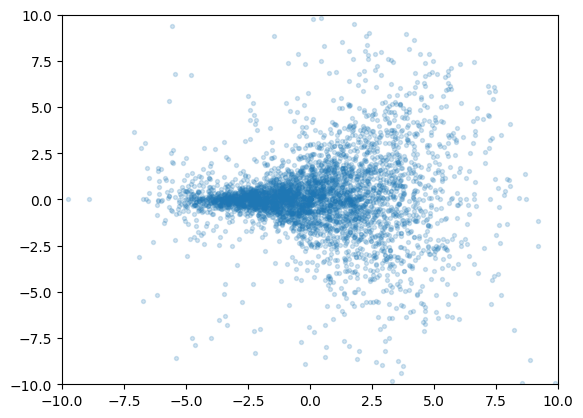

ValueError: not enough values to unpack (expected 5, got 4)

In [43]:
ys_funnel_euler = jnp.load("funnel_data/funnel_euler.npy")

# get rid of outliers
pred = lambda z: jnp.sum(jnp.abs(z), axis=-1, keepdims=True) > 100
ys_funnel_euler_pruned = jnp.where(
    pred(ys_funnel_euler), jnp.zeros(()), ys_funnel_euler
)

_, _, _, _, fig_euler = evaluate_funnel(ys_funnel_euler_pruned, geps_euler)
fig_euler.savefig("graphs/funnel_euler_const.pdf")

Gradient evaluations per effective sample: 401.5657382918161
Max mean err: 0.201, max cov err: 0.3365, min_pval: 1.17e-18, min_ess 0.1226
Avg mean err: 0.04709, avg cov err: 0.02782, avg_pval: 0.1739, avg_ess 0.1328


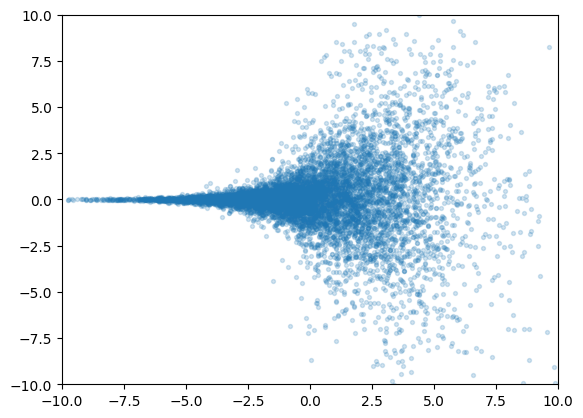

In [6]:
ys_funnel_sort_adap = jnp.load("funnel_data/funnel_sort_adap.npy")
_, _, _, _, fig_sort_adap = evaluate_funnel(ys_funnel_sort_adap, geps_sort_adap)
fig_sort_adap.savefig("graphs/funnel_sort_adap.pdf")

Gradient evaluations per effective sample: 8765.264808671598
Max mean err: 0.1054, max cov err: 0.4482, min_pval: 9.356e-24, min_ess 0.09448
Avg mean err: 0.03219, avg cov err: 0.02256, avg_pval: 0.3441, avg_ess 0.1244


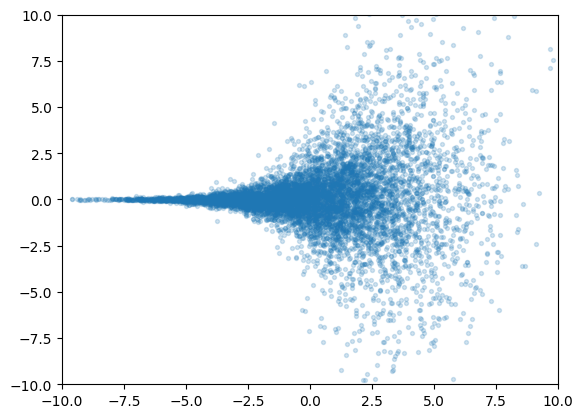

In [6]:
ys_funnel_sort = jnp.load("funnel_data/funnel_sort.npy")

# Get rid of outliers
# pred = lambda z: jnp.sum(jnp.abs(z), axis=-1, keepdims=True) > 100
# ys_funnel_sort_pruned = jnp.where(pred(ys_funnel_sort), jnp.zeros(()), ys_funnel_sort)
# ys_funnel_sort_pruned = jnp.clip(ys_funnel_sort, -11.0, 11.0)
ys_funnel_sort_pruned = ys_funnel_sort
_, _, _, _, fig_sort_const = evaluate_funnel(ys_funnel_sort_pruned, geps_sort)
fig_sort_const.savefig("graphs/funnel_sort_const.pdf")

Max mean err: 0.08001, max cov err: 0.03848, min_pval: 0.1341, min_ess 1.0
Avg mean err: 0.02212, avg cov err: 0.005724, avg_pval: 0.5594, avg_ess 1.0


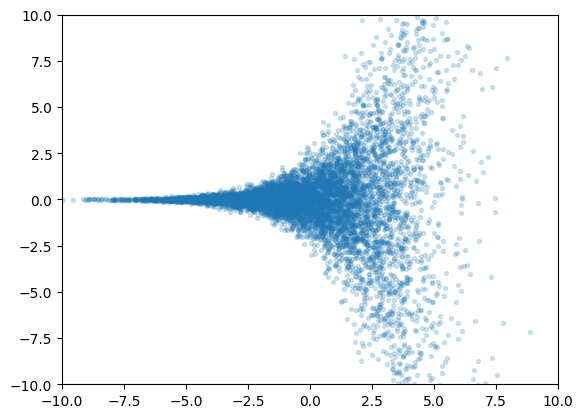

In [42]:
# True samples
keys = jr.split(jr.PRNGKey(0), 2**13)
ys_funnel_true = funnel_true_samples(keys)
_ = evaluate_funnel(ys_funnel_true)